In [1]:
# Not needed.  Code is embedded in stress modules.
# Adds lag and exponent columns to hist_all.csv and CCARscen_all.csv tables.
# 20170410: expanded to handle CCAR sUE adjustments through 2017
# 20180314: expanded to handle CCAR sUE adjustments through 2018
# creates UE_adj.csv file for sUE calcs
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## new file for econ variables only:  add lags, exponents, then save for future use.
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

In [3]:
## history vars: 4q lags & 4q differences for UE, HPI, CRE (also, try 6q & 8q lags for UE only)
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']
hs['UE_42'] = hs['UE_4'] * hs['UE_4']

hsx = hs.copy()
hsx[hsx['Date']>'2001-01-01'].tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  ...  \
167 2017-12-31    2.3    5.1   2.3   5.1  4.1  3.3  1.2  2.1   2.4  ...   
168 2018-03-31    2.2    4.3   4.4   7.0  4.1  3.5  1.6  2.5   2.8  ...   
169 2018-06-30    4.2    7.6   1.8   3.8  3.9  1.7  1.8  2.8   2.9  ...   
170 2018-09-30    3.4    4.9   2.4   4.0  3.8  2.0  2.0  2.8   2.9  ...   
171 2018-12-31    2.7    4.6   2.7   4.4  3.8  1.8  2.3  2.9   3.0  ...   

     Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  UE_42  
167    4.3  27673.0  196.0  283.0  13.1   4.8  185.0  265.0  16.81  23.04  
168    4.5  27383.0  199.0  277.0  37.3   4.6  187.0  260.0  16.81  21.16  
169    4.8  28314.0  202.0  293.0  23.6   4.4  190.0  269.0  15.21  19.36  
170    5.0  30190.0  204.0  286.0  16.1   4.3  193.0  274.0  14.44  18.49  
171    5.3  25725.0  205.0  287.0  36.1   4.1  196.0  283.0  14.44  16.81  

[5 rows x 22 columns]

In [4]:
hsx.to_csv("hist_lagexp.csv")
hsy = hsx[hsx['Date']>'2001-01-01'].copy()
hsy.set_index('Date',drop=True,inplace=True)
hsy.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  ...  \
Date                                                                 ...   
2017-12-31    2.3    5.1   2.3   5.1  4.1  3.3  1.2  2.1   2.4  3.9  ...   
2018-03-31    2.2    4.3   4.4   7.0  4.1  3.5  1.6  2.5   2.8  4.2  ...   
2018-06-30    4.2    7.6   1.8   3.8  3.9  1.7  1.8  2.8   2.9  4.6  ...   
2018-09-30    3.4    4.9   2.4   4.0  3.8  2.0  2.0  2.8   2.9  4.6  ...   
2018-12-31    2.7    4.6   2.7   4.4  3.8  1.8  2.3  2.9   3.0  5.0  ...   

            Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  \
Date                                                                        
2017-12-31    4.3  27673.0  196.0  283.0  13.1   4.8  185.0  265.0  16.81   
2018-03-31    4.5  27383.0  199.0  277.0  37.3   4.6  187.0  260.0  16.81   
2018-06-30    4.8  28314.0  202.0  293.0  23.6   4.4  190.0  269.0  15.21   
2018-09-30    5.0  30190.0  204.0  286.0  16.1   4.3  193.0  274.0  14.44   
2018-12-31    5.3  25725.0  205.0  287.0  36.1   4.1  196.0  283.0  14.44   

            UE_42  
Date               
2017-12-31  23.04  
2018-03-31  21.16  
2018-06-30  19.36  
2018-09-30  18.49  
2018-12-31  16.81  

[5 rows x 21 columns]

In [5]:
hsy.columns

Index(['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'T3m', 'T5y', 'T10y',
       'BBB', 'Mort', 'Prime', 'DJ', 'HPI', 'CRE', 'VIX', 'UE_4', 'HPI_4',
       'CRE_4', 'UE2', 'UE_42'],
      dtype='object')

In [6]:
ccy = cc.copy()
ccy['UE_4'] = ccy.groupby(['CCAR','Scen'])[['UE']].shift(4)
ccy['HPI_4'] = ccy.groupby(['CCAR','Scen'])[['HPI']].shift(4)
ccy['CRE_4'] = ccy.groupby(['CCAR','Scen'])[['CRE']].shift(4)
#test.columns = ['UE_4','HPI_4','CRE_4']
ccy.tail(26)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE  CPI  T3m  ...  BBB  \
296  2019  Adv 2019-06-30   -4.0   -1.9  -4.1  -2.4   5.1  2.0  0.2  ...  4.6   
297  2019  Adv 2019-09-30   -2.8   -0.9  -2.3  -0.6   5.7  1.9  0.1  ...  4.8   
298  2019  Adv 2019-12-31   -1.6    0.4  -1.1   0.7   6.2  2.0  0.1  ...  4.9   
299  2019  Adv 2020-03-31   -1.0    1.0  -0.6   1.4   6.6  2.2  0.1  ...  4.7   
300  2019  Adv 2020-06-30    0.2    2.4   0.2   1.9   6.8  2.0  0.1  ...  4.6   
301  2019  Adv 2020-09-30    0.9    3.0   0.5   2.5   7.0  2.1  0.1  ...  4.4   
302  2019  Adv 2020-12-31    2.5    4.6   1.5   3.4   7.0  2.1  0.1  ...  4.3   
303  2019  Adv 2021-03-31    2.9    4.9   2.3   4.3   6.9  2.2  0.1  ...  4.3   
304  2019  Adv 2021-06-30    3.1    5.2   1.9   3.9   6.7  2.2  0.1  ...  4.2   
305  2019  Adv 2021-09-30    3.3    5.3   1.9   3.9   6.6  2.1  0.1  ...  4.1   
306  2019  Adv 2021-12-31    3.4    5.4   1.9   3.8   6.4  2.1  0.1  ...  4.0   
307  2019  Adv 2022-03-31    3.4    5.3   1.8   3.7   6.3  2.1  0.1  ...  3.8   
308  2019  Sev 2018-12-31    2.7    4.6   2.7   4.4   3.8  1.8  2.3  ...  5.0   
309  2019  Sev 2019-03-31   -5.0   -3.5  -5.1  -4.2   4.7  1.2  0.3  ...  5.3   
310  2019  Sev 2019-06-30   -9.4   -7.7  -7.1  -5.8   6.3  1.6  0.2  ...  6.1   
311  2019  Sev 2019-09-30   -7.2   -5.7  -4.8  -3.4   7.5  1.7  0.1  ...  6.5   
312  2019  Sev 2019-12-31   -5.0   -3.4  -3.2  -1.6   8.4  1.8  0.1  ...  6.5   
313  2019  Sev 2020-03-31   -3.8   -2.1  -2.4  -0.7   9.2  1.9  0.1  ...  6.2   
314  2019  Sev 2020-06-30   -1.5    0.5  -1.2   0.4   9.7  1.8  0.1  ...  5.8   
315  2019  Sev 2020-09-30   -0.3    1.6  -0.6   1.2  10.0  2.0  0.1  ...  5.5   
316  2019  Sev 2020-12-31    2.9    4.8   1.2   3.0   9.9  2.0  0.1  ...  5.1   
317  2019  Sev 2021-03-31    3.6    5.4   2.3   4.3   9.7  2.1  0.1  ...  5.0   
318  2019  Sev 2021-06-30    4.1    5.9   2.2   4.2   9.5  2.1  0.1  ...  4.7   
319  2019  Sev 2021-09-30    4.4    6.2   2.3   4.3   9.2  2.1  0.1  ...  4.4   
320  2019  Sev 2021-12-31    4.6    6.4   2.5   4.3   8.9  2.0  0.1  ...  4.0   
321  2019  Sev 2022-03-31    4.6    6.3   2.4   4.2   8.6  2.0  0.1  ...  3.7   

     Mort  Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4  
296   3.6    3.2  21695.0  198.0  280.0  43.1   NaN    NaN    NaN  
297   3.7    3.1  20527.0  194.0  275.0  39.2   NaN    NaN    NaN  
298   3.8    3.1  20045.0  190.0  267.0  34.9   3.8  205.0  287.0  
299   3.7    3.1  20200.0  185.0  259.0  30.5   4.3  201.0  283.0  
300   3.7    3.1  20609.0  181.0  252.0  27.3   5.1  198.0  280.0  
301   3.6    3.1  21024.0  178.0  244.0  25.3   5.7  194.0  275.0  
302   3.5    3.1  21633.0  176.0  239.0  23.5   6.2  190.0  267.0  
303   3.6    3.1  22248.0  176.0  237.0  22.5   6.6  185.0  259.0  
304   3.7    3.1  23033.0  178.0  237.0  21.4   6.8  181.0  252.0  
305   3.7    3.1  23792.0  179.0  237.0  20.8   7.0  178.0  244.0  
306   3.6    3.1  24621.0  182.0  238.0  20.3   7.0  176.0  239.0  
307   3.6    3.1  25537.0  184.0  239.0  20.1   6.9  176.0  237.0  
308   4.8    5.3  25725.0  205.0  287.0  36.1   NaN    NaN    NaN  
309   3.9    3.3  17836.0  199.0  280.0  67.8   NaN    NaN    NaN  
310   4.2    3.2  14694.0  193.0  272.0  70.0   NaN    NaN    NaN  
311   4.4    3.1  13317.0  186.0  262.0  61.3   NaN    NaN    NaN  
312   4.5    3.1  12862.0  178.0  247.0  49.9   3.8  205.0  287.0  
313   4.3    3.1  13462.0  170.0  232.0  38.4   4.7  199.0  280.0  
314   4.2    3.1  14421.0  163.0  217.0  31.2   6.3  193.0  272.0  
315   4.1    3.1  15479.0  156.0  202.0  26.9   7.5  186.0  262.0  
316   3.9    3.1  16847.0  152.0  192.0  23.3   8.4  178.0  247.0  
317   3.9    3.1  17788.0  151.0  187.0  22.5   9.2  170.0  232.0  
318   3.8    3.1  19352.0  153.0  187.0  21.4   9.7  163.0  217.0  
319   3.8    3.1  21039.0  154.0  187.0  20.8  10.0  156.0  202.0  
320   3.6    3.1  22940.0  157.0  189.0  20.3   9.9  152.0  192.0  
321   3.5    3.1  25137.0  160.0  191.0  20.1   9

In [7]:
for i in np.arange(len(ccy)):
  if np.isnan(ccy.iloc[i]['UE_4']):
    yr = ccy.iloc[i]['Date'].year - 1
    mn = ccy.iloc[i]['Date'].month
    dy = ccy.iloc[i]['Date'].day
    dd = str(datetime(yr,mn,dy))[0:7]
    xu = hsy[dd]['UE'].values
    ccy.loc[i,'UE_4'] = xu
    xh = hsy[dd]['HPI'].values
    ccy.loc[i,'HPI_4'] = xh
    xc = hsy[dd]['CRE'].values
    ccy.loc[i,'CRE_4'] = xc

ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m  ...   BBB  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0  ...  4.90   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1  ...  4.52   
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1  ...  4.55   
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1  ...  4.59   
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1  ...  4.74   
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1  ...  4.89   
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1  ...  5.15   
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1  ...  5.32   

   Mort  Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4  
0  4.20    NaN  11677.00  132.00  177.00  48.00   9.5  136.00  167.00  
1  4.21    NaN  11936.09  137.21  172.17  35.97   9.5  134.00  168.00  
2  4.17    NaN  12090.22  137.55  173.29  35.08   9.0  133.00  171.00  
3  4.15    NaN  12242.03  137.89  175.43  31.83   9.1  133.00  173.00  
4  4.19    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  
5  4.24    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  
6  4.34    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  
7  4.41    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  

[8 rows x 22 columns]

In [8]:
ccy['UE2'] = ccy['UE'] * ccy['UE']
ccy['UE_42'] = ccy['UE_4'] * ccy['UE_4']
ccy.to_csv('CCARscen_lagexp.csv')
ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m  ...  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0  ...   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1  ...   
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1  ...   
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1  ...   
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1  ...   
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1  ...   
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1  ...   
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1  ...   

   Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4      UE2  \
0    NaN  11677.00  132.00  177.00  48.00   9.5  136.00  167.00  81.0000   
1    NaN  11936.09  137.21  172.17  35.97   9.5  134.00  168.00  82.8100   
2    NaN  12090.22  137.55  173.29  35.08   9.0  133.00  171.00  82.8100   
3    NaN  12242.03  137.89  175.43  31.83   9.1  133.00  173.00  81.0000   
4    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  79.2100   
5    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  79.2100   
6    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  75.5161   
7    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  71.9104   

   UE_42  
0  90.25  
1  90.25  
2  81.00  
3  82.81  
4  81.00  
5  82.81  
6  82.81  
7  81.00  

[8 rows x 24 columns]

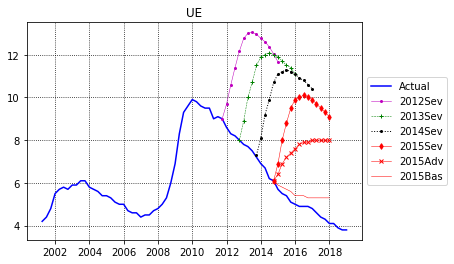

In [9]:
vv = 'UE'
hsx1 = hsx[hsx['Date']>'2001-01-01']
hsx1.set_index('Date', drop=True, inplace=True)
cc2 = ccy[['Date','CCAR','Scen',vv]]
cc2['YrSc'] = cc2.apply(lambda x: str(x['CCAR'])+x['Scen'],axis=1)
cc2p = cc2.pivot('Date','YrSc',vv)
#cc2p.head()
hsx2 = hsx1.merge(cc2p, how='outer', left_index=True, right_index=True)
#hsx2.tail()

x = list(hsx2.index)

plt.plot(x,hsx2[vv],c='b',label='Actual')
plt.plot(x,hsx2['2012Sev'],ls='-',c='m',lw=.5,marker='.',ms=4,label='2012Sev')
plt.plot(x,hsx2['2013Sev'],ls='--',c='g',lw=.5,marker='+',ms=4,label='2013Sev')
plt.plot(x,hsx2['2014Sev'],ls=':',c='k',lw=1,marker='.',ms=4,label='2014Sev')
plt.plot(x,hsx2['2015Sev'],c='r',lw=.5,marker='d',ms=4,label='2015Sev')
plt.plot(x,hsx2['2015Adv'],c='r',lw=.5,marker='x',ms=4,label='2015Adv')
plt.plot(x,hsx2['2015Bas'],c='r',lw=.5,label='2015Bas')
plt.title(vv)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.savefig(vv+'_chart.png', dpi=400, bbox_inches='tight')
plt.show()

In [10]:
hsue = pd.DataFrame(hsy.loc['2001':'2019']['UE'])
hsue.reset_index(drop=False, inplace=True)
hsue.tail()

Date   UE
67 2017-12-31  4.1
68 2018-03-31  4.1
69 2018-06-30  3.9
70 2018-09-30  3.8
71 2018-12-31  3.8

In [12]:
ccs = ccy[ccy['Scen']=='Sev'][['CCAR','Date','UE']]
ccs = ccs.pivot('Date','CCAR','UE')
ccs.reset_index(drop=False, inplace=True)
ccs.columns = ['Date','u12','u13','u14','u15','u16','u17','u18','u19']
ccs.tail(8)

Date  u12  u13  u14  u15  u16  u17  u18   u19
35 2020-06-30  NaN  NaN  NaN  NaN  NaN  NaN  9.5   9.7
36 2020-09-30  NaN  NaN  NaN  NaN  NaN  NaN  9.2  10.0
37 2020-12-31  NaN  NaN  NaN  NaN  NaN  NaN  8.9   9.9
38 2021-03-31  NaN  NaN  NaN  NaN  NaN  NaN  8.6   9.7
39 2021-06-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.5
40 2021-09-30  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.2
41 2021-12-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.9
42 2022-03-31  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.6

In [13]:
hsue2 = hsue.merge(ccs,how='outer',on='Date')
hsue2.set_index('Date', drop=True, inplace=True)
hsue2.tail(8)

UE  u12  u13  u14  u15  u16  u17  u18   u19
Date                                                   
2020-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.5   9.7
2020-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.2  10.0
2020-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.9   9.9
2021-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.6   9.7
2021-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.5
2021-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.2
2021-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.9
2022-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.6

In [14]:
hsue2['Qn'] = hsue2.index.year * 4 + hsue2.index.month /3
hsue2['Qn'] = hsue2['Qn'].astype(int)
hsue2.tail(8)

UE  u12  u13  u14  u15  u16  u17  u18   u19    Qn
Date                                                         
2020-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.5   9.7  8082
2020-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.2  10.0  8083
2020-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.9   9.9  8084
2021-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.6   9.7  8085
2021-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.5  8086
2021-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   9.2  8087
2021-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.9  8088
2022-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   8.6  8089

In [15]:
mx = hsue2[['UE','u12','u13','u14','u15','u16','u17','u18','u19']].max()
mx = pd.DataFrame(mx)
mx.columns = ['mx']
mxdct = mx.to_dict()
mxdct['mx']

{'UE': 9.9,
 'u12': 13.05,
 'u13': 12.1,
 'u14': 11.3,
 'u15': 10.1,
 'u16': 10.0,
 'u17': 10.0,
 'u18': 10.0,
 'u19': 10.0}

In [16]:
mxd = hsue2[hsue2['UE']==mxdct['mx']['UE']]['Qn']
mxd12 = hsue2[hsue2['u12']==mxdct['mx']['u12']]['Qn']
mxd13 = hsue2[hsue2['u13']==mxdct['mx']['u13']]['Qn']
mxd14 = hsue2[hsue2['u14']==mxdct['mx']['u14']]['Qn']
mxd15 = hsue2[hsue2['u15']==mxdct['mx']['u15']]['Qn']
mxd16 = hsue2[hsue2['u16']==mxdct['mx']['u16']]['Qn']
mxd17 = hsue2[hsue2['u17']==mxdct['mx']['u17']]['Qn']
mxd18 = hsue2[hsue2['u18']==mxdct['mx']['u18']]['Qn']
mxd19 = hsue2[hsue2['u19']==mxdct['mx']['u19']]['Qn']
mxd15

Date
2016-06-30    8066
Name: Qn, dtype: int32

In [17]:
mxq = pd.DataFrame(pd.concat([mxd,mxd12,mxd13,mxd14,mxd15,mxd16,mxd17,mxd18,mxd19]))
mxq.reset_index(drop=False, inplace=True)
ux=pd.Series(['UE','u12','u13','u14','u15','u16','u17','u18','u19'])
mxq = mxq.assign(ux=ux.values)
mxq.set_index('ux',drop=True,inplace=True)
mxq

Date    Qn
ux                  
UE  2009-12-31  8040
u12 2013-06-30  8054
u13 2014-06-30  8058
u14 2015-06-30  8062
u15 2016-06-30  8066
u16 2017-09-30  8071
u17 2018-09-30  8075
u18 2019-09-30  8079
u19 2020-09-30  8083

In [18]:
mx2 = mx.merge(mxq, how='inner', left_index=True, right_index=True)
mx2.reset_index(drop=False,inplace=True)
mx2

index     mx       Date    Qn
0    UE   9.90 2009-12-31  8040
1   u12  13.05 2013-06-30  8054
2   u13  12.10 2014-06-30  8058
3   u14  11.30 2015-06-30  8062
4   u15  10.10 2016-06-30  8066
5   u16  10.00 2017-09-30  8071
6   u17  10.00 2018-09-30  8075
7   u18  10.00 2019-09-30  8079
8   u19  10.00 2020-09-30  8083

In [19]:
hmx = mx2[mx2['index']=='UE']['mx'][0]
hqn = mx2[mx2['index']=='UE']['Qn'][0]

# calcs incremental adjustment to curr UE rate per period:
for i in np.arange(len(mx2)):
  mx2.loc[i,'adj'] = (1 - hmx / mx2.loc[i,'mx']  )
  mx2.loc[i,'inc'] = (1 - hmx / mx2.loc[i,'mx']  )  /(mx2.loc[i,'Qn'] - hqn)

mx2

index     mx       Date    Qn       adj       inc
0    UE   9.90 2009-12-31  8040  0.000000       NaN
1   u12  13.05 2013-06-30  8054  0.241379  0.017241
2   u13  12.10 2014-06-30  8058  0.181818  0.010101
3   u14  11.30 2015-06-30  8062  0.123894  0.005632
4   u15  10.10 2016-06-30  8066  0.019802  0.000762
5   u16  10.00 2017-09-30  8071  0.010000  0.000323
6   u17  10.00 2018-09-30  8075  0.010000  0.000286
7   u18  10.00 2019-09-30  8079  0.010000  0.000256
8   u19  10.00 2020-09-30  8083  0.010000  0.000233

In [20]:
hsue2.to_csv('uescaledata.csv')

In [21]:
mx2.to_csv("uescaleparam.csv")

In [22]:
ues = pd.DataFrame(hsue2['Qn'])
ues['adj'] = 1
ues.reset_index(drop=False, inplace=True)
ues.head()

Date    Qn  adj
0 2001-03-31  8005    1
1 2001-06-30  8006    1
2 2001-09-30  8007    1
3 2001-12-31  8008    1
4 2002-03-31  8009    1

In [23]:
## 2012 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u12']['Date']))

inc = np.float(mx2[mx2['index']=='u12']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u12']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj12'}, inplace=True)
ues.head()

Date    Qn  adj12
0 2001-03-31  8005    1.0
1 2001-06-30  8006    1.0
2 2001-09-30  8007    1.0
3 2001-12-31  8008    1.0
4 2002-03-31  8009    1.0

In [24]:
## 2013 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u13']['Date']))

inc = np.float(mx2[mx2['index']=='u13']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u13']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj13'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13
0 2001-03-31  8005    1.0    1.0
1 2001-06-30  8006    1.0    1.0
2 2001-09-30  8007    1.0    1.0
3 2001-12-31  8008    1.0    1.0
4 2002-03-31  8009    1.0    1.0

In [25]:
## 2014 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u14']['Date']))

inc = np.float(mx2[mx2['index']=='u14']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u14']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj14'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14
0 2001-03-31  8005    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0

In [26]:
## 2015 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u15']['Date']))

inc = np.float(mx2[mx2['index']=='u15']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u15']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj15'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15
0 2001-03-31  8005    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0

In [27]:
## 2016 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u16']['Date']))

inc = np.float(mx2[mx2['index']=='u16']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u16']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj16'}, inplace=True)
ues.tail()

Date    Qn     adj12     adj13     adj14     adj15  adj16
80 2021-03-31  8085  0.758621  0.818182  0.876106  0.980198   0.99
81 2021-06-30  8086  0.758621  0.818182  0.876106  0.980198   0.99
82 2021-09-30  8087  0.758621  0.818182  0.876106  0.980198   0.99
83 2021-12-31  8088  0.758621  0.818182  0.876106  0.980198   0.99
84 2022-03-31  8089  0.758621  0.818182  0.876106  0.980198   0.99

In [28]:
## 2017 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u17']['Date']))

inc = np.float(mx2[mx2['index']=='u17']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u17']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj17'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0

In [29]:
## 2018 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u18']['Date']))

inc = np.float(mx2[mx2['index']=='u18']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u18']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj18'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17  adj18
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0    1.0

In [30]:
## 2019 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u19']['Date']))

inc = np.float(mx2[mx2['index']=='u19']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u19']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj19'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17  adj18  adj19
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0

In [31]:
ues.drop('Qn', axis=1, inplace=True)
ues.tail()

Date     adj12     adj13     adj14     adj15  adj16  adj17  adj18  \
80 2021-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99   
81 2021-06-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99   
82 2021-09-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99   
83 2021-12-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99   
84 2022-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99   

    adj19  
80   0.99  
81   0.99  
82   0.99  
83   0.99  
84   0.99

In [32]:
ues.to_csv("UE_adj.csv")

In [33]:
ues[35:64]

Date     adj12     adj13     adj14     adj15     adj16     adj17  \
35 2009-12-31  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
36 2010-03-31  0.982759  0.989899  0.994368  0.999238  0.999677  0.999714   
37 2010-06-30  0.965517  0.979798  0.988737  0.998477  0.999355  0.999429   
38 2010-09-30  0.948276  0.969697  0.983105  0.997715  0.999032  0.999143   
39 2010-12-31  0.931034  0.959596  0.977474  0.996954  0.998710  0.998857   
40 2011-03-31  0.913793  0.949495  0.971842  0.996192  0.998387  0.998571   
41 2011-06-30  0.896552  0.939394  0.966211  0.995430  0.998065  0.998286   
42 2011-09-30  0.879310  0.929293  0.960579  0.994669  0.997742  0.998000   
43 2011-12-31  0.862069  0.919192  0.954948  0.993907  0.997419  0.997714   
44 2012-03-31  0.844828  0.909091  0.949316  0.993145  0.997097  0.997429   
45 2012-06-30  0.827586  0.898990  0.943685  0.992384  0.996774  0.997143   
46 2012-09-30  0.810345  0.888889  0.938053  0.991622  0.996452  0.996857   
47 2012-12-31  0.793103  0.878788  0.932422  0.990861  0.996129  0.996571   
48 2013-03-31  0.775862  0.868687  0.926790  0.990099  0.995806  0.996286   
49 2013-06-30  0.758621  0.858586  0.921158  0.989337  0.995484  0.996000   
50 2013-09-30  0.758621  0.848485  0.915527  0.988576  0.995161  0.995714   
51 2013-12-31  0.758621  0.838384  0.909895  0.987814  0.994839  0.995429   
52 2014-03-31  0.758621  0.828283  0.904264  0.987053  0.994516  0.995143   
53 2014-06-30  0.758621  0.818182  0.898632  0.986291  0.994194  0.994857   
54 2014-09-30  0.758621  0.818182  0.893001  0.985529  0.993871  0.994571   
55 2014-12-31  0.758621  0.818182  0.887369  0.984768  0.993548  0.994286   
56 2015-03-31  0.758621  0.818182  0.881738  0.984006  0.993226  0.994000   
57 2015-06-30  0.758621  0.818182  0.876106  0.983244  0.992903  0.993714   
58 2015-09-30  0.758621  0.818182  0.876106  0.982483  0.992581  0.993429   
59 2015-12-31  0.758621  0.818182  0.876106  0.981721  0.992258  0.993143   
60 2016-03-31  0.758621  0.818182  0.876106  0.980960  0.991935  0.992857   
61 2016-06-30  0.758621  0.818182  0.876106  0.980198  0.991613  0.992571   
62 2016-09-30  0.758621  0.818182  0.876106  0.980198  0.991290  0.992286   
63 2016-12-31  0.758621  0.818182  0.876106  0.980198  0.990968  0.992000   

       adj18     adj19  
35  1.000000  1.000000  
36  0.999744  0.999767  
37  0.999487  0.999535  
38  0.999231  0.999302  
39  0.998974  0.999070  
40  0.998718  0.998837  
41  0.998462  0.998605  
42  0.998205  0.998372  
43  0.997949  0.998140  
44  0.997692  0.997907  
45  0.997436  0.997674  
46  0.997179  0.997442  
47  0.996923  0.997209  
48  0.996667  0.996977  
49  0.996410  0.996744  
50  0.996154  0.996512  
51  0.995897  0.996279  
52  0.995641  0.996047  
53  0.995385  0.995814  
54  0.995128  0.995581  
55  0.994872  0.995349  
56  0.994615  0.995116  
57  0.994359  0.994884  
58  0.994103  0.994651  
59  0.993846  0.994419  
60  0.993590  0.994186  
61  0.993333  0.993953  
62  0.993077  0.993721  
63  0.992821  0.993488